In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.3 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149864 sha256=a9997f6778b7d93a887ede46c41b74dced4e54f488850646be3a5837f4a40a5c
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [4]:
%cd /content/drive/MyDrive/University/CS232.M22.KHCL/FinalProject

/content/drive/MyDrive/University/CS232.M22.KHCL/FinalProject


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import glob
import librosa

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [5]:
!wget https://ailab.hcmus.edu.vn/assets/vivos.tar.gz

--2022-06-26 14:07:31--  https://ailab.hcmus.edu.vn/assets/vivos.tar.gz
Resolving ailab.hcmus.edu.vn (ailab.hcmus.edu.vn)... 115.73.213.165, 14.241.254.131, 14.161.23.204
Connecting to ailab.hcmus.edu.vn (ailab.hcmus.edu.vn)|115.73.213.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1474408300 (1.4G) [application/octet-stream]
Saving to: ‘vivos.tar.gz’

vivos.tar.gz        100%[===================>]   1.37G  6.48MB/s    in 3m 41s  

2022-06-26 14:11:15 (6.37 MB/s) - ‘vivos.tar.gz’ saved [1474408300/1474408300]



In [6]:
!tar -xf vivos.tar.gz

In [7]:
import os

# cd to the folder contains file .tar.gz of the dataset
data_path = "vivos"
train_data_path = os.path.join(data_path, "train")
test_data_path = os.path.join(data_path, "test")

# Read metadata file and parse it
train_prompts_path = os.path.join(train_data_path, "prompts.txt")
test_prompts_path = os.path.join(test_data_path, "prompts.txt")

train_wavs_path = os.path.join(train_data_path, "waves")
test_wavs_path = os.path.join(test_data_path, "waves")

with open(train_prompts_path, encoding="utf8") as f:
  data = f.read()
  lines = data.split("\n")
  train_file_path = []
  train_transcription = []
  for line in lines:
    instance = line.split(" ", 1)
    if len(instance) == 1:
      continue
    file_path = glob.glob(os.path.join(train_wavs_path, "**", instance[0] + ".wav"))[0]
    train_file_path.append(file_path)
    train_transcription.append(instance[1])
  d = {"file_path": train_file_path, "transcription": train_transcription}
  train_df = pd.DataFrame(d)

with open(test_prompts_path, encoding="utf8") as f:
  data = f.read()
  lines = data.split("\n")
  test_file_path = []
  test_transcription = []
  for line in lines:
    instance = line.split(" ", 1)
    if len(instance) == 1:
      continue
    file_path = glob.glob(os.path.join(test_wavs_path, "**", instance[0] + ".wav"))[0]
    test_file_path.append(file_path)
    test_transcription.append(instance[1])
  d = {"file_path": test_file_path, "transcription": test_transcription}
  test_df = pd.DataFrame(d)

In [8]:
train_df.head(3)

,file_path,transcription
0,vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R001.wav,KHÁCH SẠN
1,vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R002.wav,CHỈ BẰNG CÁCH LUÔN NỖ LỰC THÌ CUỐI CÙNG BẠN MỚ...
2,vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R003.wav,TRONG SỐ CÁC QUỐC GIA CÔNG NGHIỆP PHÁT TRIỂN


In [9]:
test_df.head(3)

,file_path,transcription
0,vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav,TRỞ NÊN THỤ ĐỘNG
1,vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R122.wav,CŨNG KHIẾN CHO HỌ DÈ DẶT
2,vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R130.wav,CHỊ GẶN HỎI ANH THỀ SỐNG THỀ CHẾT LÀ KHÔNG CÓ


In [10]:
# split = int(len(metadata_df) * 0.90)
# df_train = metadata_df[:split]
# df_val = metadata_df[split:]

print(f"Size of the training set: {train_df.shape[0]}")
print(f"Size of the training set: {test_df.shape[0]}")

Size of the training set: 11660
Size of the training set: 760


In [11]:
# The set of characters accepted in the transcription.
lowercase_chars = string.ascii_lowercase
accented_chars = "àáãạảăắằẳẵặâấầẩẫậèéẹẻẽêềếểễệđìíĩỉịòóõọỏôốồổỗộơớờởỡợùúũụủưứừửữựỳỵỷỹý"
punctuation_chars = string.punctuation
final_chars = lowercase_chars + accented_chars + punctuation_chars + " "
characters = [x for x in final_chars]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'ã', 'ạ', 'ả', 'ă', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'â', 'ấ', 'ầ', 'ẩ', 'ẫ', 'ậ', 'è', 'é', 'ẹ', 'ẻ', 'ẽ', 'ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'đ', 'ì', 'í', 'ĩ', 'ỉ', 'ị', 'ò', 'ó', 'õ', 'ọ', 'ỏ', 'ô', 'ố', 'ồ', 'ổ', 'ỗ', 'ộ', 'ơ', 'ớ', 'ờ', 'ở', 'ỡ', 'ợ', 'ù', 'ú', 'ũ', 'ụ', 'ủ', 'ư', 'ứ', 'ừ', 'ử', 'ữ', 'ự', 'ỳ', 'ỵ', 'ỷ', 'ỹ', 'ý', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '] (size =127)


In [12]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80



def encode_single_sample(wav_file, label):
    """
    Describes the transformation that we apply to each element of our dataset
    """
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file
    audio, sampling_rate = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    stfts = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(stfts) # get absolute value of complex number
    spectrogram = tf.math.pow(spectrogram, 2) # get power 

    # 6. mel spectrogram
    num_spectrogram_bins = stfts.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sampling_rate, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # 8. normalisation
    means = tf.math.reduce_mean(log_mel_spectrograms, 1, keepdims=True)
    stddevs = tf.math.reduce_std(log_mel_spectrograms, 1, keepdims=True)
    log_mel_spectrograms = (log_mel_spectrograms - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 9. Convert label to Lower case
    label = tf.strings.lower(label, encoding="utf-8")
    # 10. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Map the characters in label to numbers
    label = char_to_num(label)
    # 12. Return a dict as our model is expecting two inputs
    return log_mel_spectrograms, label

In [13]:
batch_size = 8
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["file_path"]), list(train_df["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test_df["file_path"]), list(test_df["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

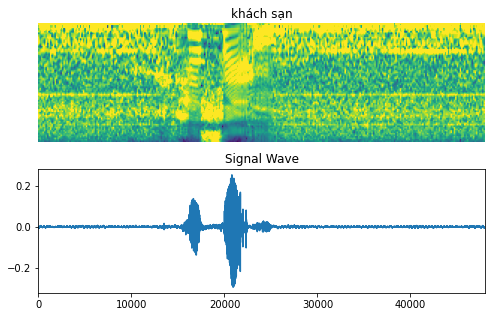

In [14]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(train_df["file_path"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [15]:
def CTCLoss(y_true, y_pred):
    """
    Define CTC loss function
    """
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [16]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=num_mel_bins,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 80)]                          0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 80, 1)                         0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 40, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 40, 32)                     

In [17]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs.
epochs = 200
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
model_name = f"model_gru_logmalescale_epochs{epochs}_bs{batch_size}"

checkpoint_filepath = os.path.join("/content/drive/MyDrive/University/CS232.M22.KHCL/FinalProject", "ckpt", "checkpoint_epoch-{epoch:02d}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint_callback],
)

Epoch 1/200
1458/1458 [==============================] - ETA: 0s - loss: 180.9742----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9918
----------------------------------------------------------------------------------------------------
Target    : chắc sắp tới thu xếp đi du lịch thôi
Prediction: c sc
----------------------------------------------------------------------------------------------------
Target    : thật sự mà là bởi lòng hận thù
Prediction:  m   ln ôn 
----------------------------------------------------------------------------------------------------
1458/1458 [==============================] - 1387s 933ms/step - loss: 180.9742 - val_loss: 125.8844
Epoch 2/200
1458/1458 [==============================] - ETA: 0s - loss: 94.7873----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9044
-----------------------------------------------------

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

In [ ]:
model.save('model')

In [ ]:
!zip -r 'model_gru_logmalescale_batchsize_8_epochs_200' model